In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
seed = 42

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QfAUt0u4wLZVy2Ta1G90jOLNaqzAw2eW' -O agnews_test.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UsOBTnfch-Su4kqmkzXcIizwJt6NWtXZ' -O agnews_train.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XWzN3nBPcWp50f_DjC2rpS7G2PvzjvmB' -O business.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u3KQGgkFTN8s4fTGzJJOsmR4MGVlusp1' -O science.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g_gYaij_xn1HwGebruK3JJRZy30P7E49' -O sports.txt
clear_output()


In [3]:
labels = ['sports', 'business', 'science']

# dataset is saved in a CSV file with no header and each column in separated by comma
# the file has the following structure: gold_label , title , body
df = pd.read_csv('agnews_train.csv', header=None)

# in the dataset gold labels are given as: 1 (World), 2 (Sports), 3 (Business), 4 (Science/Technology)
# we discard all the rows with gold label 1 (World) and we keep all the other rows
df = df[df[0] != 1]

# we create a 'label' column, subtract 2 from each gold label so we obtain a direct mapping with our list of labels:
# 0 -> sports ; 1 -> business ; 2 -> science
df['label'] = df[0]-2

# we concatenate title and body to obtain a unified text
df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
# remove the original 3 columns to obtain our final processed dataset, containing 2 columns: label and text
# the original 3 columns are the unmatched labels, the titles and the bodies
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

,label,text
0,1,Wall St. Bears Claw Back Into the Black (Reute...
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,1,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,1,Iraq Halts Oil Exports from Main Southern Pipe...
4,1,"Oil prices soar to all-time record, posing new..."
5,1,"Stocks End Up, But Near Year Lows (Reuters) Re..."
6,1,Money Funds Fell in Latest Week (AP) AP - Asse...
7,1,Fed minutes show dissent over inflation (USATO...
8,1,Safety Net (Forbes.com) Forbes.com - After ear...
9,1,Wall St. Bears Claw Back Into the Black NEW Y...


In [4]:
def get_features_text(text: str):
  """
    Calculated text features for the given text.
    Args:
        text (string): string containing the text.
    Returns:
        List with dimension 4: list containing the features extracted from the text in the order [ln text_len, # sports words, # business words, # science words].
    """
  words = text.split()
  features = [math.log(len(words))]

  # labels = ['sports', 'business', 'science']
  for label in labels:
    with open(f'{label}.txt', 'r') as label_file:
      # label_words - in file each word is on a new line
      label_words = label_file.read().split('\n')
    label_count = 0
    # for each word in the text,

    for word in words:
      if word in label_words:
        label_count += 1
    features.append(label_count)

  # return the features list [ln text_len, # sports words, # business words, # science words]
  return features

In [5]:
# create a new column containing the features calculated as described in get_features_text
processed_df['text_features'] = [get_features_text(text) for text in processed_df['text']]
processed_df.head(10)

,label,text,text_features
0,1,Wall St. Bears Claw Back Into the Black (Reute...,"[3.044522437723423, 0, 0, 0]"
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...,"[3.58351893845611, 1, 1, 0]"
2,1,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[3.58351893845611, 0, 3, 0]"
3,1,Iraq Halts Oil Exports from Main Southern Pipe...,"[3.58351893845611, 0, 0, 0]"
4,1,"Oil prices soar to all-time record, posing new...","[3.6109179126442243, 0, 1, 0]"
5,1,"Stocks End Up, But Near Year Lows (Reuters) Re...","[3.6375861597263857, 0, 0, 1]"
6,1,Money Funds Fell in Latest Week (AP) AP - Asse...,"[3.5553480614894135, 0, 3, 0]"
7,1,Fed minutes show dissent over inflation (USATO...,"[3.6635616461296463, 0, 4, 0]"
8,1,Safety Net (Forbes.com) Forbes.com - After ear...,"[4.219507705176107, 1, 8, 0]"
9,1,Wall St. Bears Claw Back Into the Black NEW Y...,"[3.1354942159291497, 0, 0, 0]"


In [6]:
# extract X (text_featues) and y (label) from the dataset
X = np.array(processed_df['text_features'].to_list())
y_train = processed_df['label'].to_list()

In [7]:
# Check dataset shapes
print(f"Dataset inputs or features shape (num_samples, num_features): {X.shape}") # -> (90000, 4)
assert X.shape == (90000, 4)
print(f"Dataset outputs or labels shape (num_samples, ): {len(y_train)}") # -> 90000
assert len(y_train) == 90000

Dataset inputs or features shape (num_samples, num_features): (90000, 4)
Dataset outputs or labels shape (num_samples, ): 90000


In [8]:
def standardise_features(X: np.ndarray):
    """
      Standardise the features contained in the given dataset.
      Args:
          X (array): array with dimension (num_samples, num_features).
      Returns:
          array with dimension (num_samples, num_features): dataset with standardised features.
    """
    # Check means and standard deviations for each features
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    print("Means of features:", means)
    print("Standard deviations of features:", stds)

    # If not standardised, apply Standard Scaling (Z-score standardisation)
    if any(stds != 1) or any(means != 0):
        scaler = StandardScaler()
        standardised_X = scaler.fit_transform(X)
        after_means = X.mean(axis=0)
        after_stds = X.std(axis=0)
        print("\nMeans of features after standardisation:", after_means)
        print("Standard deviations of features after standardisation:", after_stds)
    else:
        print("Dataset is already standardised.")
    return standardised_X

In [9]:
X_standardised = standardise_features(X) #standardise train set

Means of features: [3.59162699 0.60902222 1.05572222 0.10733333]
Standard deviations of features: [0.25684052 1.0002015  1.26235914 0.36428255]

Means of features after standardisation: [3.59162699 0.60902222 1.05572222 0.10733333]
Standard deviations of features after standardisation: [0.25684052 1.0002015  1.26235914 0.36428255]


# `Not using X_standardised below`

In [10]:
# Add bias term to X
X_train = np.c_[np.ones(X_standardised.shape[0]), X] # not using X_standardised

In [11]:
# Check training sets shapes
print(f"Training set shape (num_samples x (num_features+bias)): {X_train.shape}") # -> (90000, 5)
assert X_train.shape == (90000, 5)

Training set shape (num_samples x (num_features+bias)): (90000, 5)


In [12]:
def softmax(Z: np.ndarray):
  """
    Softmax function that gives us the predictions of the given samples using our model.

    Args:
        Z (array): array with dimension (num_train_samples, num_class), each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

    Returns:
        array with dimension (num_train_samples, num_class): array containing a prediction made by the model for each sample.
  """
  ## INSERT YOUR CODE HERE ##
  exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
  return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
  ## END OF YOUR CODE ##

In [13]:
# Initialize weights

## INSERT YOUR CODE HERE ##
num_classes = len(np.unique(y_train))
weights = np.zeros((X_train.shape[1], num_classes))
## END OF YOUR CODE ##

# Check weights shape
print(f"Weights Shape (num_features+bias, num_classes): {weights.shape}") # -> (5, 3)
assert weights.shape == (5, 3)

Weights Shape (num_features+bias, num_classes): (5, 3)


In [14]:
# Learning rate and number of iterations
learning_rate = 0.001
num_iterations = 5000

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Z Shape (num_train_samples, num_class): (90000, 3)
Predictions Shape (num_train_samples, num_class): (90000, 3)
Error Shape (num_train_samples, ): (90000, 3)
Gradient Shape (num_features+bias, num_class): (5, 3)
Weights Shape (num_features+bias, num_class): (5, 3)


Training: 100%|██████████| 5000/5000 [02:22<00:00, 35.07it/s]


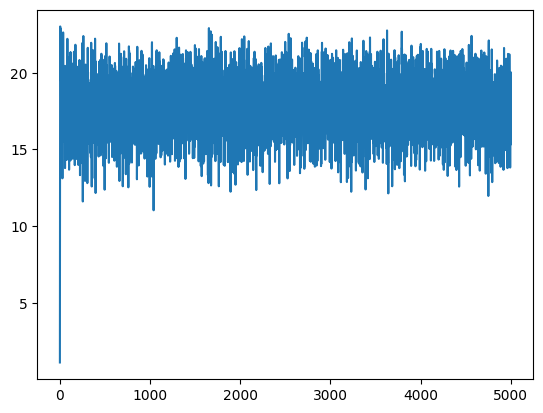

In [15]:
# Training the model
# You can comment the print functions for a clear output after you complete coding all the training steps.
losses = []
for i in tqdm(range(num_iterations), total=num_iterations, desc="Training"):

  ## INSERT YOUR CODE HERE ##
  # 1. Calculate Z
  # X_train: (num_train_samples, num_features+bias) x weights: (num_features+bias, num_class) -> Z: (num_train_samples, num_class)
  Z = np.dot(X_train, weights)
  if i==0:
    print('Z Shape (num_train_samples, num_class):', Z.shape) # -> (90000, 3)
    assert Z.shape == (90000, 3)

  # 2. Get predictions
  # Z: (num_train_samples, num_class) -> predictions: (num_train_samples, num_class)
  predictions = softmax(Z)
  if i==0:
    print('Predictions Shape (num_train_samples, num_class):', predictions.shape) # -> (90000, 3)
    assert predictions.shape == (90000, 3)

  # 3. Compute error between prediction and real label
  '''
  The prediction for each data item is a vector of probabilites summing to 1.
  For example, if we have a prediction for a data point like this: [0.2, 0.5, 0.3],
  we can read this as there is 0.2 probability that the data item belongs to the first class,
  0.5 to the second class, and 0.3 to the third class. Our gold label is just the index
  of the class, taking the values 0, 1 or 2. Let's assume our gold label is 2.
  To compare our predictions to the label, we need to represent the label in a comparable format.
  To achieve this, we can use one-hot encoding for the labels (setting 1 in the desired index and 0 elsewhere),
  giving the following for a label of 2: [0, 0, 1].
  This we can compare to the prediction, finding that we are off by 0.7 from the perfect true class probability (1).

  Hint: to get the one-hot encoding of the labels (y_train in our case), think about using np.eye() function
  '''
  # predictions: (num_train_samples, num_class) y_train: (num_train_samples, ) -> errors: (num_train_samples, num_class)
  y_train_one_hot = np.eye(num_classes)[y_train]
  errors = predictions - y_train_one_hot
  if i==0:
    print('Error Shape (num_train_samples, ):', errors.shape)  # -> (90000, 3)
    assert errors.shape == (90000, 3)

  # 4. Calculate gradient
  #  We transpose X_train to align the dimensions correctly with the error dimension for matrix multiplication.
  # X_train.T: (num_features+bias, num_train_samples) x error: (num_train_samples, num_class) -> gradient or change in weights vector: (num_features+bias, num_class)
  gradients = np.dot(X_train.T, errors)
  if i==0:
    print('Gradient Shape (num_features+bias, num_class):', gradients.shape)  # -> (5, 3)
    assert gradients.shape == (5, 3)

  # 5. Update weights
  # gradient: (num_features+bias, num_class) -> weights: (num_features+bias, num_class)
  weights -= learning_rate * gradients
  if i==0:
    print('Weights Shape (num_features+bias, num_class):', weights.shape) # -> (5, 3)
    assert weights.shape == (5, 3)
  ## END OF YOUR CODE ##

  loss = -np.sum(y_train_one_hot * np.log(predictions+ 1e-15)) / len(y_train) # Add small epsilon to avoid log(0)
  losses.append(loss)

plt.plot(losses)
plt.show()

In [16]:
def prepocess_data(filename):
  """
    Preprocess the given dataset to set it in the correct format, i.e.
    containing 2 columns (label, text_features) with standardised text features and adding bias to the features.
    This function collects all the steps described in details in Sections 2.1 and 2.2

    Args:
        filename (string): name of the file containing the dataset.

    Returns:
        X: bias+features extracted from the samples in the dataset.
        y: gold labels of the dataset.
  """
  df = pd.read_csv(filename, header=None)
  df = df[df[0] != 1]
  df['label'] = df[0]-2
  df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
  df = df.drop(columns=[0,1,2])

  df['text_features'] = [get_features_text(text) for text in df['text']]

  X = np.array(df['text_features'].to_list())
  X_standardised = standardise_features(X) #standardise test set
  X = np.c_[np.ones(X_standardised.shape[0]), X_standardised]

  y = df['label'].to_list()

  return X, y

X_test, y_test = prepocess_data('agnews_test.csv')

print(f"Test set shape (num_test_samples , (num_features+bias)): {X_test.shape}") # -> (5700, 5)
assert X_test.shape == (5700, 5)

Means of features: [3.59003788 0.61403509 1.04561404 0.10666667]
Standard deviations of features: [0.25611934 1.00182966 1.25712987 0.36107701]

Means of features after standardisation: [3.59003788 0.61403509 1.04561404 0.10666667]
Standard deviations of features after standardisation: [0.25611934 1.00182966 1.25712987 0.36107701]
Test set shape (num_test_samples , (num_features+bias)): (5700, 5)


In [17]:
# Making predictions on the test set using trained weights
# X_test: (num_test_samples, num_features) x weights: (num_features, num_class) -> Z: (num_samples, num_class)
z = np.dot(X_test, weights)
test_predictions = softmax(z)

# select the class with the highest probability
multiclass_predictions = np.argmax(test_predictions, axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, multiclass_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.48473684210526313
